<a href="https://colab.research.google.com/github/JonasVerbickas/test-jupyter/blob/main/NLP_CW2_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
import nltk
import torch
import os
import re
import collections
import random
from gensim.models import Word2Vec
from matplotlib import pyplot as plt

In [141]:
nltk.download('punkt')
nltk.download('stopwords')
porter = nltk.PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [142]:
PATH_TO_REVIEWS = "/content/drive/MyDrive/Colab Notebooks/product_reviews"

In [143]:
file_contents = ""
for filename in os.listdir(PATH_TO_REVIEWS):
  # skip readme
  if filename == 'README.txt':
    continue
  # append contents of other files to file_contents string
  starting_corpus_size = len(file_contents)
  with open(os.path.join(PATH_TO_REVIEWS, filename)) as f:
    file_contents += f.read()
  print("After appending", filename, "corpus sized increased to", starting_corpus_size, "->", len(file_contents))

After appending Nokia_6600.txt corpus sized increased to 0 -> 56093
After appending norton.txt corpus sized increased to 56093 -> 95013
After appending Linksys_Router.txt corpus sized increased to 95013 -> 151947
After appending MicroMP3.txt corpus sized increased to 151947 -> 259727
After appending Diaper_Champ.txt corpus sized increased to 259727 -> 294831
After appending Hitachi_router.txt corpus sized increased to 294831 -> 325078
After appending Canon_S100.txt corpus sized increased to 325078 -> 353887
After appending Canon_PowerShot_SD500.txt corpus sized increased to 353887 -> 378520
After appending ipod.txt corpus sized increased to 378520 -> 436566


In [144]:
list_of_sentences = nltk.tokenize.sent_tokenize(file_contents)
list_of_sentences[:5]

["[t]\nphone[+3][u]##I've had this beauty for nearly 2 months now and I truely love it.",
 'battery life[-2]##The only disappointment so far has been battery life.',
 "battery life[-2][u]##Mine generally requires a charege every 48 hours or so and I don't really talk on it that much.",
 '##Why is this phone so great?',
 '##Simple.']

## 1. Preprocessing


In [145]:
# this map is from https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py
# I found it via https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72
# removing contractions ensures more matches with stop-words and fixes the inconsitency of apostrohpes between stop-words and tokenizer
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}
# this will remove apostrophes and solve the issue of inconsistency between tokenization and stop-words
def expandContractions(text):
  """
  This function will iterate through the whole list of contractions
  and replace all contracted forms in the given text with the full-length versions
  """
  for k, v in CONTRACTION_MAP.items():
    text = text.replace(k, v)
  return text

In [146]:
def textPreprocessing(list_of_sentences):
  output = []
  for text_as_string in list_of_sentences:
    processed_sentence = []
    case_folded = text_as_string.casefold()
    folded_and_expanded_contractions = expandContractions(case_folded)
    tokenized = nltk.tokenize.word_tokenize(folded_and_expanded_contractions)
    for token in tokenized:
      if token in nltk.corpus.stopwords.words('english'):
        continue
      # if token doesn't contain alphanumeric characters
      if re.match('^\W+$', token):
        continue
      # if token is encodes semantic information
      if re.match('^[+-]\d$', token):
        continue
      stemmed = porter.stem(token)
      processed_sentence.append(stemmed)
    output.append(processed_sentence)
  return output

In [147]:
tokenized_and_preprocessed = textPreprocessing(list_of_sentences)
tokenized_and_preprocessed[:5]

[['phone', 'u', 'beauti', 'nearli', '2', 'month', 'trueli', 'love'],
 ['batteri', 'life', 'disappoint', 'far', 'batteri', 'life'],
 ['batteri',
  'life',
  'u',
  'mine',
  'gener',
  'requir',
  'chareg',
  'everi',
  '48',
  'hour',
  'realli',
  'talk',
  'much'],
 ['phone', 'great'],
 ['simpl']]

## 2. Pseudowords

In [148]:
def getTop50Words(list_of_tokenized_sentences):
  # unwrap the sublists
  list_of_all_tokens = [token for sent in list_of_tokenized_sentences for token in sent]
  top_50_tokens = collections.Counter(list_of_all_tokens).most_common()[:50]
  # top_50_tokens has a format of ('word', number_of_occurances)
  # in our case we only need to check if tokens match and don't need the number of occurances
  top_50_without_freq = [t[0] for t in top_50_tokens]
  return top_50_without_freq

In [149]:
def replaceTopWordsWithPseudo(list_of_tokenized_sentences, top_50_without_freq):
  output = []
  for list_of_tokenized_words in list_of_tokenized_sentences:
    pseudoworded_sentence = []
    for token in list_of_tokenized_words:
      if token not in top_50_without_freq:
        continue
      # reverse 50% of occurances
      if random.uniform(0, 1) > 0.5:
        pseudoworded_sentence.append(token[::-1])
      else:
        pseudoworded_sentence.append(token)
    if len(pseudoworded_sentence) > 0:
      output.append(pseudoworded_sentence)
  return output
      

In [150]:
top_50_words = getTop50Words(tokenized_and_preprocessed)
top_50_words

['use',
 'phone',
 'u',
 'router',
 'one',
 'get',
 'ipod',
 'camera',
 'player',
 'work',
 'batteri',
 'diaper',
 'like',
 'would',
 'product',
 'great',
 'time',
 'featur',
 'problem',
 'good',
 'look',
 'zen',
 'qualiti',
 'instal',
 'also',
 'sound',
 "'s",
 'take',
 'need',
 'softwar',
 'comput',
 'pictur',
 'want',
 'realli',
 'micro',
 'go',
 'well',
 'even',
 'thing',
 'easi',
 'buy',
 'creativ',
 'first',
 'review',
 'make',
 'much',
 'bag',
 'size',
 'better',
 'champ']

In [151]:
half_replaced_with_pseudo = replaceTopWordsWithPseudo(tokenized_and_preprocessed,
                                                      top_50_words)
half_replaced_with_pseudo[:5]

[['enohp', 'u'],
 ['batteri', 'irettab'],
 ['batteri', 'u', 'illaer', 'much'],
 ['enohp', 'taerg'],
 ['enohp']]

## 3. D-dimensional vector to encode top 50

In [161]:
def generateWordEmbeddings(list_of_sentences):
    w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=2)
    w2v_model.build_vocab(half_replaced_with_pseudo, progress_per=10000)
    w2v_model.train(half_replaced_with_pseudo, total_examples=w2v_model.corpus_count, epochs=1000, report_delay=1)
    w2v_model.init_sims(replace=True)
    return w2v_model.wv 

In [162]:
wv = generateWordEmbeddings(half_replaced_with_pseudo)

In [163]:
matrix = [] 
for word in top_50_words:
  matrix.append(wv[word])
  matrix.append(wv[word[::-1]])

## 4. Apply clustering

In [173]:
class ClustererWrapper:
  """
  Wrapper class designed to make it easier to test different clustering algorithms.
  """
  def __init__(self, cluster_fn, classify_fn, matrix):
    self.cluster_fn = cluster_fn
    self.classify_fn = classify_fn
    cluster_fn(matrix)


In [176]:
clusterer = nltk.cluster.KMeansClusterer(50, nltk.cluster.euclidean_distance, avoid_empty_clusters=True)
wrapped_clusterer = ClustererWrapper(cluster_fn=lambda matrix: clusterer.cluster(matrix, True),
                                     classify_fn=lambda word: clusterer.classify(word),
                                     matrix=matrix)


## 5. Check whether word and its corresponding pseudoword are grouped together

In [189]:
def testClusteringAlgo(matrix, wrapped_clusterer):
  correct_clusterings = 0
  incorrect_clusterings = 0
  for word in top_50_words:
    pseudoword = word[::-1]
    word_vector = wv[word]
    pseudoword_vector = wv[pseudoword] 
    word_class = wrapped_clusterer.classify_fn(word_vector)
    pseudoword_class = wrapped_clusterer.classify_fn(pseudoword_vector)
    if word_class == pseudoword_class:
      correct_clusterings += 1
    else:
      incorrect_clusterings += 1
    
  print("correct_clusterings", correct_clusterings, "| incorrect_clusterings", incorrect_clusterings)
  return correct_clusterings, incorrect_clusterings

In [190]:
testClusteringAlgo(matrix, wrapped_clusterer)

correct_clusterings 23 | incorrect_clusterings 27


(23, 27)

## 6. Run the clustering process 5-10 times

In [198]:
def runMultipleClusterings(number_of_runs=10):
  accuracy_history = []
  for run in range(number_of_runs):
    clusterer = nltk.cluster.KMeansClusterer(50, nltk.cluster.euclidean_distance, avoid_empty_clusters=True)
    wrapped_clusterer = ClustererWrapper(cluster_fn=lambda matrix: clusterer.cluster(matrix, True),
                                        classify_fn=lambda word: clusterer.classify(word),
                                        matrix=matrix)
    correct, incorrect = testClusteringAlgo(matrix, wrapped_clusterer)
    accuracy_history.append(correct/(correct+incorrect))
  return accuracy_history


In [215]:
accuracy_hist = runMultipleClusterings(10)

correct_clusterings 22 | incorrect_clusterings 28
correct_clusterings 23 | incorrect_clusterings 27
correct_clusterings 23 | incorrect_clusterings 27
correct_clusterings 20 | incorrect_clusterings 30
correct_clusterings 16 | incorrect_clusterings 34
correct_clusterings 20 | incorrect_clusterings 30
correct_clusterings 22 | incorrect_clusterings 28
correct_clusterings 22 | incorrect_clusterings 28
correct_clusterings 20 | incorrect_clusterings 30
correct_clusterings 23 | incorrect_clusterings 27


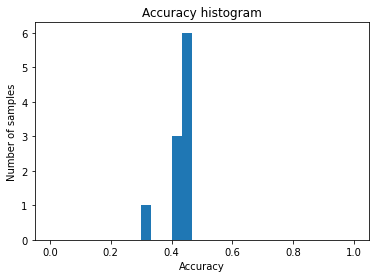

In [216]:
plt.title("Accuracy histogram")
plt.xlabel("Accuracy")
plt.ylabel("Number of samples")
plt.hist(accuracy_hist, bins=30, range=(0, 1))
plt.show()